In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
dates_to_visualize = [
                                                                                            "2018-09", "2018-10", "2018-11", "2018-12",
    "2019-01", "2019-02", "2019-03", "2019-04", "2019-05", "2019-06", "2019-07", "2019-08", "2019-09", "2019-10", "2019-11", "2019-12",
    "2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09", "2020-10", "2020-11", "2020-12",
    "2021-01", "2021-02", "2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12",
    "2022-01", "2022-02", "2022-03", "2022-04", "2022-05", "2022-06", "2022-07", "2022-08", "2022-09", "2022-10", "2022-11", "2022-12",
    "2023-01", "2023-02", "2023-03", "2023-04", "2023-05", "2023-06", "2023-07", "2023-08", "2023-09", "2023-10", "2023-11", "2023-12",
    "2024-01", "2024-02", "2024-03", "2024-04", 
]

In [3]:
available_data_files = list(Path("../data/httparchive_metrics/nel_monitored_resource_types").glob("*.parquet"))

used_data_files = list(filter(lambda file: file.stem in dates_to_visualize, available_data_files))
used_data_files

[WindowsPath('../data/httparchive_metrics/nel_monitored_resource_types/2018-09.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_monitored_resource_types/2018-10.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_monitored_resource_types/2018-11.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_monitored_resource_types/2018-12.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_monitored_resource_types/2019-02.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_monitored_resource_types/2019-03.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_monitored_resource_types/2019-04.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_monitored_resource_types/2019-05.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_monitored_resource_types/2019-06.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_monitored_resource_types/2019-07.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_monitored_resource_types/2019-08.parquet'),
 WindowsPa

In [4]:
from results.result_utils import date_to_text_format, concat_data_from_files

result = concat_data_from_files(used_data_files)

result['date_formatted'] = result['date'].map(date_to_text_format)

result

,date,url_domain,type,count,date_formatted
0,2018-09,m2.cn.bing.com,html,1,Sep 2018
1,2018-09,www4.bing.com,html,1,Sep 2018
0,2018-10,classifieds.seloc.org,image,52,Oct 2018
1,2018-10,classifieds.seloc.org,script,12,Oct 2018
2,2018-10,classifieds.seloc.org,html,1,Oct 2018
...,...,...,...,...,...
11161376,2024-04,zzzzap.nl,css,88,Apr 2024
11161377,2024-04,zzzzap.nl,font,2,Apr 2024
11161378,2024-04,zzzzzz.me,script,1,Apr 2024
11161379,2024-04,zzzzzz.me,html,2,Apr 2024


### Monitored resources by type

In [5]:
monthly_data = pd.DataFrame()
for month in dates_to_visualize:
    current_month_data = result[result['date'] == month].copy()
    
    current_month_data = current_month_data.groupby(['date', 'type'], as_index=False).agg({'count': 'sum'})
    current_month_data.sort_values(by='count', ascending=False, inplace=True)
    current_month_data.reset_index(inplace=True, drop=True)
    
    current_month_data['date'] = current_month_data['date'].map(date_to_text_format)
    
    monthly_data = pd.concat([monthly_data, current_month_data])
    
# TODO analyze on domains that have a % of NEL monitored resources < 100% (lower ranges 10%-20%)
    
monthly_data

,date,type,count
0,Sep 2018,html,2
0,Oct 2018,image,57
1,Oct 2018,script,15
2,Oct 2018,html,13
3,Oct 2018,css,4
...,...,...,...
6,Apr 2024,text,988706
7,Apr 2024,video,374217
8,Apr 2024,audio,49869
9,Apr 2024,xml,43535


#### GRAPH - Monthly monitored resources distribution by type

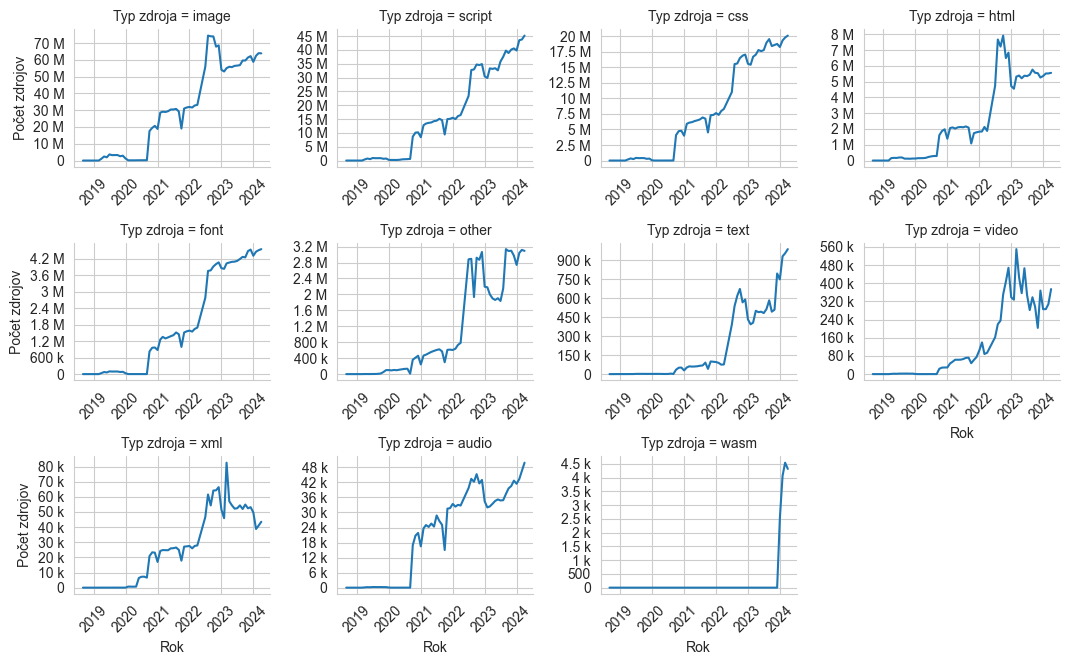

In [9]:
data = monthly_data.copy()
data['count'] = data['count'].astype('int64')

data['date_fmt'] = data['date'].map(lambda date: pd.to_datetime(date))

data.rename(columns={'type': 'Typ zdroja', 'date_fmt': 'Dátum', 'count': 'Počet'}, inplace=True)

pivoted_data = data.pivot_table(index='Typ zdroja', columns='Dátum', values='Počet').fillna(0)

to_plot = pivoted_data

to_plot = to_plot.stack()
to_plot = to_plot.reset_index()
to_plot.rename(columns={0: 'Počet'}, inplace=True)

sns.set_style('whitegrid')

g = sns.relplot(to_plot, kind='line', x='Dátum', y='Počet',
                col='Typ zdroja', col_wrap=4, 
                col_order=['image', 'script', 'css', 'html', 'font', 'other', 'text', 'video', 'xml', 'audio', 'wasm'],
                height=2.25, aspect=1.2, 
                facet_kws={'sharey': False, 'sharex': False}
                )

for idx, ax in enumerate(g.axes):
    ax.xaxis.remove_overlapping_locs = False
    years = mdates.YearLocator()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    ax.xaxis.set_minor_locator(ticker.NullLocator())

    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(ticker.EngFormatter())

    ax.tick_params(axis='x', which="major", rotation=45)


g.set_xlabels("Rok")
g.set_ylabels("Počet zdrojov")

g.tight_layout()

g.savefig("graphs/httparchive_nel_resource_types_dist.pdf")

#### GRAPH - Monthly monitored resources distribution by type (FIRST 2 YEARS OF NEL) 

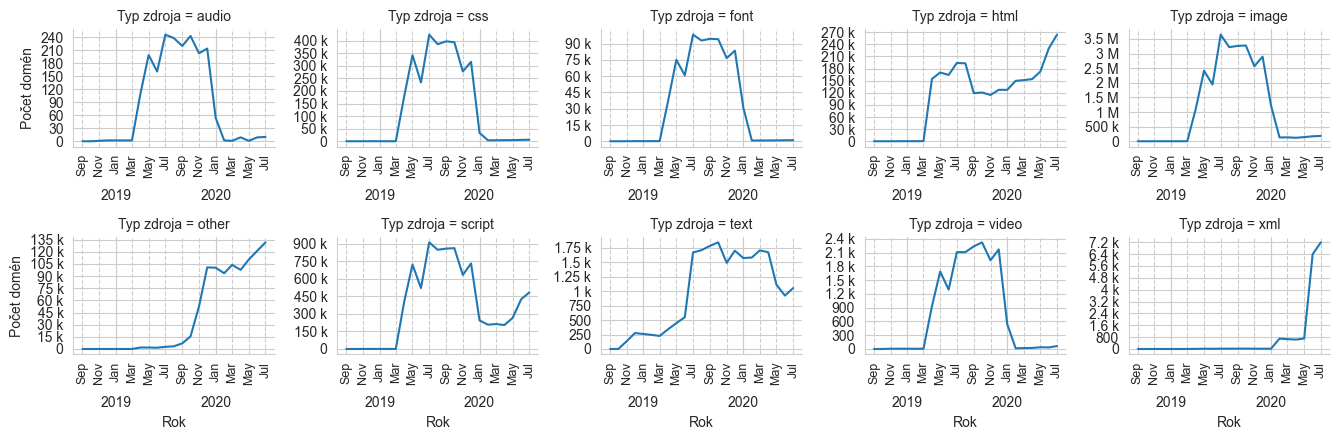

In [7]:
to_plot2 = to_plot.copy()
to_plot2 = to_plot2[to_plot2['Dátum'] < pd.to_datetime('2020-08-01')]
to_plot2 = to_plot2[to_plot2['Typ zdroja'] != 'wasm']
# to_plot2

sns.set_style('whitegrid')

g = sns.relplot(to_plot2, kind='line', x='Dátum', y='Počet', 
                col='Typ zdroja', col_wrap=5,
                height=2.25, aspect=1.2, 
                facet_kws={'sharey': False, 'sharex': False}
                )

for idx, ax in enumerate(g.axes):
    ax.xaxis.remove_overlapping_locs = False
    years = mdates.YearLocator()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("\n\n%Y"))
    ax.grid(True, axis='x', which='minor', linestyle='--',)

    months = mdates.MonthLocator(interval=2)
    months_fmt = mdates.DateFormatter('%b')
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(months_fmt)
    ax.tick_params(axis='x', which="minor", rotation=90, labelsize=9)

    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))   
    ax.yaxis.set_major_formatter(ticker.EngFormatter())    

    ax.tick_params(axis='x', which="major", rotation=0)


g.set_xlabels("Rok")
g.set_ylabels("Počet domén")

g.tight_layout()

g.savefig("graphs/httparchive_nel_resource_types_dist_until_2022.pdf")

### Most monitored resource type for the whole time period (HTTPArchive data) 

In [8]:
result.groupby('type')['count'].sum().sort_values(ascending=False)

type
image     1902713942
script    1052837202
css        504339581
html       165380225
font       115861667
other       68147313
text        14392533
video        8637731
xml          1691787
audio        1359757
wasm           15444
Name: count, dtype: UInt32